In [1]:
%pylab inline
import numpy as np
import skbio

Populating the interactive namespace from numpy and matplotlib


In [2]:
percent_id = 82

unaligned_ref_fp = 'gg_13_8_otus/rep_set/%d_otus.fasta' % percent_id
aligned_ref_fp = 'gg_13_8_otus/rep_set_aligned/%d_otus.fasta' % percent_id
tax_ref_fp = 'gg_13_8_otus/taxonomy/%d_otu_taxonomy.txt' % percent_id

In [3]:
from skbio import DNA

fwd_primer = DNA("GTGCCAGCMGCCGCGGTAA", {'label':'fwd-primer'})
rev_primer = DNA("GGACTACHVGGGTWTCTAAT", {'label':'rev-primer'}).reverse_complement()

In [4]:
def get_regex_from_seq(seq):
    result = []
    for base in seq:
        if str(base) in DNA.nondegenerate_chars | DNA.gap_chars:
            result.append(str(base))
        else:
            result.append('[%s]' % ''.join(DNA.degenerate_map[str(base)]))

    return ''.join(result)

regex = '({0}.*{1})'.format(get_regex_from_seq(fwd_primer), 
                            get_regex_from_seq(rev_primer))

print regex
print('(GTGCCAGC[AC]GCCGCGGTAA.*ATTAGA[AT]ACCC[CTG][ATG]GTAGTCC)')

(GTGCCAGC[AC]GCCGCGGTAA.*ATTAGA[AT]ACCC[CTG][ATG]GTAGTCC)
(GTGCCAGC[AC]GCCGCGGTAA.*ATTAGA[AT]ACCC[CTG][ATG]GTAGTCC)


In [5]:
seq_count = 0
trimmed_seqs = []
starts = []
stops = []

# how do we tell read to read into DNA sequence objects so we have access to gaps()
for seq in skbio.io.read(aligned_ref_fp, format='fasta'):
    seq = DNA(seq)
    seq_count += 1
    for i in seq.find_with_regex(regex, ignore=seq.gaps()):
        starts.append(i.start)
        stops.append(i.stop)
        
print(min(starts))
print(np.median(starts))
print(max(starts))
print(min(stops))
print(np.median(stops))
print(max(stops))

mean_start = round(np.median(starts))
mean_stop = round(np.median(stops))

2227
2227.0
2227
4090
4090.0
4090


In [6]:
kmer_counts = []
seq_ids = []

for seq in skbio.io.read(aligned_ref_fp, format='fasta'):
    seq_ids.append(seq.metadata['id'])
    sliced_seq = DNA(seq[mean_start:mean_stop]).degap()
    del sliced_seq.metadata
    sliced_kmer_frequencies = sliced_seq.kmer_frequencies(8)
    kmer_counts.append(dict(sliced_kmer_frequencies))

In [7]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer()
X = v.fit_transform(kmer_counts)

In [8]:
taxa_dic = {}

with open(tax_ref_fp) as f:
    for line in f:
       (key, val) = line.strip().split('\t')
       taxa_dic[key] = val.split('; ')
        
y = np.array([taxa_dic[seq_id][2] for seq_id in seq_ids])

In [9]:
from sklearn.feature_selection import SelectPercentile

X_new = SelectPercentile().fit_transform(X, y)

In [10]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=0)

In [11]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [12]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


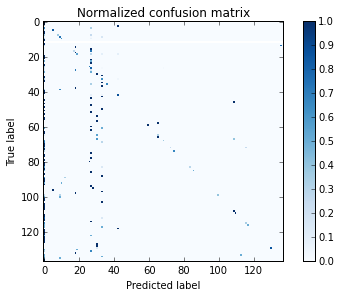

0.400508810514


/Users/jc33/.virtualenvs/skbio-pres/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/jc33/.virtualenvs/skbio-pres/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jc33/.virtualenvs/skbio-pres/lib/python2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', '

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print(f1_score(y_test, y_pred))

In [24]:
from sklearn.svm import SVC

clf = SVC(C=10, kernel='linear', degree=3, gamma=0.001)
y_pred = clf.fit(X_train, y_train).predict(X_test)

Normalized confusion matrix


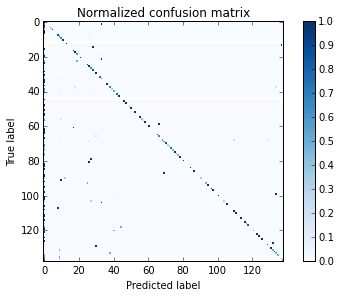

0.651169731839


/Users/jc33/.virtualenvs/skbio-pres/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [25]:
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print(f1_score(y_test, y_pred))